**Repository**: https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML

### <font color= 'orange'> S&P500 Risk Optimized Portfolios PostCovid *ML model*<font> 

#### <font color= 'lightblue'> 0. <u> Load Dependencies </u><font>

In [2]:
import functions as fn
import data as dt
import visualizations as vs 

##### <font color= 'lightblue'> 0.1 <u> Install Libs. & Modules </u><font>

##### <span style='color:green'> Project Users:</span> Install packages in requirements.txt file.<br>

`requirements.txt` libs. need to be <span style='color:green'> downloaded </span> it can be done through pip by executing:

In [2]:
dt.library_install("requirements.txt")

Requirements installed.

# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 


numpy >= 1.23.5 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8

<span style='color:lightgreen'> *You can skip this section if not contributing to the project.* <font>

##### <span style='color:red'> Project Creators:</span> Create requirements.txt file.

In [6]:
docstring = """
# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 
\n
"""

path = fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Simulation_Course_Exams\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


##### <font color= 'lightblue'> 0.2 <u> Load Libraries & Modules </u><font>

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

#### <font color= 'lightblue'> 1. <u> Data Download </u><font>

*Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions (other sources could be used instead).*<br><br>
The following are the $S\&P500$ quotes symbols from *A-Z*:

In [4]:
tickers=fn.SP500_tickers(50)
tickers[0][0:5], tickers[-1][0:5]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

<span style='color:lightgreen'> You can skip this section if you prefer to read .csv <font>

#### <font color= 'lightblue'> 1.1 <u> Fetching S&P 500 data </u><font> </span>




Now that we have downloaded in $5_m \forall$ $S\&P$ Quotes $\rightarrow$ $6_y$ we can start working with the dataset.

In [5]:
data = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)


In [10]:

data.head()


,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2017-05-09,162.314438,49.483746,40.332912,50.679874,110.669502,52.981617,35.781643,135.600006,85.669304,135.433960,...,130.407806,169.407776,115.448700,37.699100,48.241055,62.149654,98.449997,109.968346,35.134598,57.183163
2017-05-10,161.232147,49.041603,40.179420,50.534348,110.788330,54.310524,35.722523,136.149994,85.272148,135.470978,...,130.270111,169.488983,115.271034,37.800144,47.487434,62.258114,98.870003,110.737564,35.143185,57.635387
2017-05-11,161.322281,48.825054,39.601562,50.013538,110.422691,54.077724,35.502899,136.289993,85.122162,135.276382,...,130.728989,169.335602,114.298515,38.019073,47.338570,62.484070,99.099998,112.155472,34.679634,57.462196
2017-05-12,161.174728,48.310719,39.691853,50.595619,110.568954,54.329926,35.443768,136.839996,85.748734,134.414413,...,130.600555,166.565811,117.159943,38.381168,47.431618,62.276207,99.639999,112.377907,34.465050,57.616138
2017-05-15,162.043854,48.725788,39.764088,51.062832,111.748146,54.717926,35.595810,137.600006,86.878258,135.183670,...,130.738205,163.642670,117.534004,38.574848,48.650417,62.565422,100.690002,113.369537,34.799816,57.731606


In [11]:
data.to_csv("sp500.csv")
data.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,105.849998,70.139999,111.110001,153.710007,279.420013,77.430000,77.800003,374.149994,221.119995,125.470001,...,233.240005,694.020691,115.599998,70.169998,104.500000,142.229996,287.450012,138.830002,26.82,179.559998
2023-05-02,102.980003,69.779999,111.500000,151.619995,276.739990,76.000000,75.519997,368.660004,216.539993,124.120003,...,227.490005,686.890625,113.199997,69.099998,104.519997,142.899994,255.440002,143.009995,23.92,176.899994
2023-05-03,102.830002,69.459999,111.760002,149.250000,275.179993,75.230003,75.019997,345.250000,215.979996,123.800003,...,226.149994,681.705078,109.330002,68.500000,104.150002,137.309998,258.500000,139.619995,22.66,177.729996
2023-05-04,101.839996,69.190002,110.860001,147.360001,266.500000,74.589996,74.220001,335.829987,213.809998,120.239998,...,224.289993,665.640015,109.250000,69.110001,106.330002,136.320007,265.000000,136.630005,19.93,178.470001
2023-05-05,103.349998,70.379997,111.260002,148.029999,265.649994,76.000000,75.959999,348.399994,215.479996,123.769997,...,227.820007,675.510010,110.779999,69.570000,108.970001,137.490005,273.799988,137.910004,23.76,186.229996


#### <font color= 'lightblue'> 1.2 <u> Reading S&P 500 data </u><font> </span>

In [12]:
SP_Assets = pd.read_csv("Data/sp500.csv", index_col=0)

Now that we have downloaded our data we can start by obtaining $r_f$, calculating $r_{i}$ $\&$ $\sigma_i$.<br>
Until then we can calculate some well known metrics of the *market risks* involved to measure their risk-reward performance from different perspectives. 

the following ratios are metrics of *market risks* and they do not consider a benchmark: <br>

+ $R_{Sharpe} = \frac{R - {rf}}{\sigma}$

+ $R_{Sortino} = \frac{R - {rf}}{\sigma_{(r<0)}}$

The following ratios tend to be metrics of systematic risks as they both consider a benchmark.<br>

While the usage of a $\beta$ expressed in this case as $\beta$ = $\frac{Cov(R,R_{mkt})}{Var(R_{mkt})}$ anticipated that they do:<br>

+ $R_{Treynor} = \frac{R - {rf}}{\beta}$

+ $R_{Jensen} = {rf} + \beta(R_{mkt} - {rf})$ very closely related to the CAPM model.

In [18]:
def selection_data(data, rf, title):
    """
    Function to get selection summary and data with given metrics.
    Parameters:
    ----------
    data : dataframe
        Prices to model.
    rf : float
        Daily Treasury Par Yield Curve Rates for sharpe/sortino selection from the end of the period on a yearly basis. 
    Returns:
    -------
    dataframe
        Summary statistics of data selection with sharpe/sortino ratios with given data.
    """
    returns = (data.pct_change()).iloc[1:, :].dropna(axis = 1)
    # index_ret = (index.pct_change()).iloc[1:, :].dropna(axis = 1)   
    mean_ret = returns.mean() * 252 
    sharpe = (mean_ret - rf) / ( returns.std() * np.sqrt(252) )
    sortino = (mean_ret - rf) / ( returns[returns < 0].std() * np.sqrt(252) )
    treynor = (mean_ret - rf) / ( returns.mean() * 252 )
    
    
    summary = pd.DataFrame({"Annualized Return" : mean_ret, "Volatility" : returns.std() * np.sqrt(252),
                            "Sharpe Ratio" : sharpe, "Sortino Ratio" : sortino})
    
    summary = summary.nlargest(30, "Sharpe Ratio").nlargest(30, "Sortino Ratio")
    
    bars = summary.plot.bar(figsize=(20, 10), rot=90, title=title, fontsize=15, grid=True, edgecolor="black", linewidth=1)
    plt.grid(color='gray', linestyle='--')

    return summary, bars

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
ENPH,1.518291,0.789591,1.901479,3.293286
TDG,0.451852,0.255364,1.703261,2.788401
DXCM,0.786397,0.501397,1.534707,2.616126
CMG,0.602974,0.364806,1.606536,2.569614
AMD,0.920863,0.585987,1.542632,2.404627
CSGP,0.405487,0.268307,1.448293,2.364980
PAYC,0.688312,0.395736,1.696613,2.363065
FICO,0.500005,0.287623,1.679648,2.311393
KEYS,0.504359,0.319989,1.523362,2.273103
ZTS,0.344071,0.221555,1.476701,2.238899


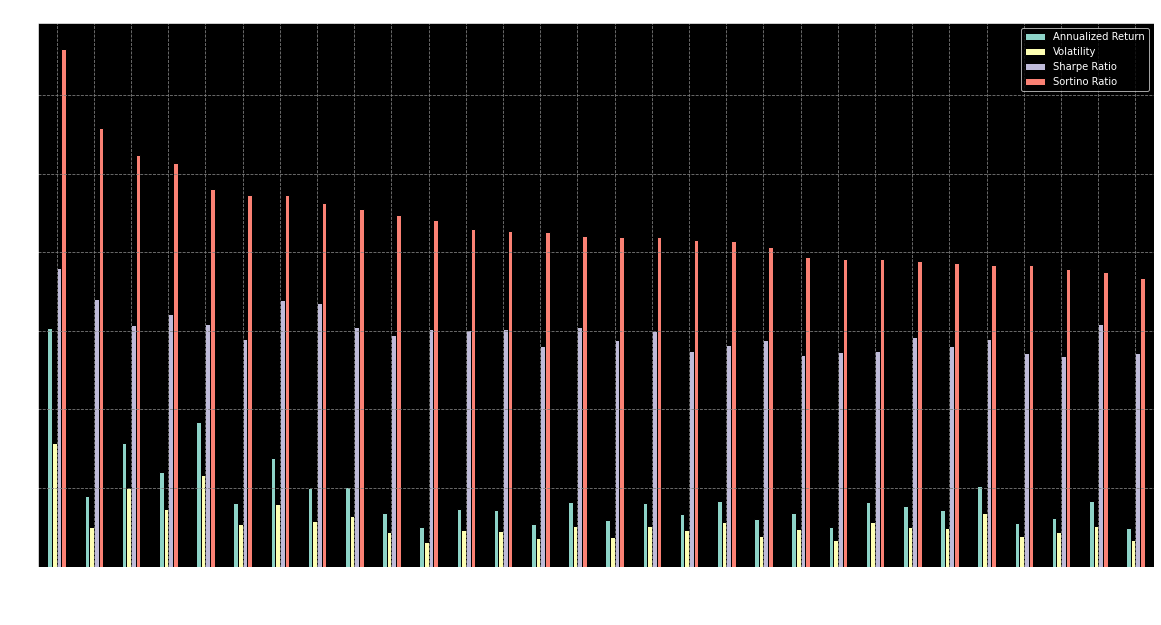

In [20]:
Asset_Selection18_20 = selection_data(SP_Assets.loc["2018-01-02":"2020-01-02"], 0.0169, "S&P500 Asset Selection 2018-2020")[0]

Asset_Selection18_20

In randomly weighted datasets $X_i=1,2,.., n$, it can be concluded that $\mu_P$ is given by:<br>    

$$\mu_{P} = \sum_{i=1}^{n} w_{i} \mu_{{X_{i}}}$$ 

Nevertheless, to calculate the variance we need the correlation coefficients of $X_{i,j}$ expressed as $\rho_{i j} = \frac{Cov(X_i, X_{j})}{\sigma_{i} \sigma_{j}}$.

While the variance can be expressed as: $$\sigma^2_P=\sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}\sigma_{i}\sigma_{j}\rho_{ij}$$<br>

When we substitute $\rho_{ij}$ we are left with: <br>

$$\sigma^2_P = \sum_{i=1}^{n}\sum_{j=1}^{n}w_{i}w_{j}Cov(X_i, X_j)$$

Which could also be expressed as a product of matrices $\times$ vectors:<br>

$$\sigma^2_{P} = (\vec{w})^{T} \times COV_{1,n} \times \vec{w}$$

Or in its expanded form:<br> 

$$\sigma^2_{P} = {\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

Therefore, we can verify that the following are the optimized portfolios for given periods: <br><br>
+ $Min_{Var{Arg_{max}}}$: <br><br>
+ $Sharpe_{Arg_{max}} \bigg(E\bigg[\frac{r_P-r_f}{\sigma}\bigg]\bigg)$ : <br><br>
+ $Sortino_{Arg_{max}} \bigg(E\bigg[\frac{r_P-r_f}{\sigma_{(r_p)<0}}\bigg]\bigg)$ : <br><br>
+ $Traynor_{Arg_{max}} \bigg(E\bigg[\frac{r_P-r_f}{\beta}\bigg]\bigg)$ : <br><br>

In [23]:
def Optimizer(Assets, index, rf, title):
    Asset_ret = (Assets.pct_change()).iloc[1:, :].dropna(axis = 1)
    index_ret = index.pct_change().iloc[1:, :].dropna(axis = 1)
    index_ret = index_ret[index_ret.index.isin(Asset_ret.index)]

    mean_ret = Asset_ret.mean() * 252
    cov = Asset_ret.cov() * 252

    N = len(mean_ret)
    w0 = np.ones(N) / N
    bnds = ((0, None), ) * N
    cons = {"type" : "eq", "fun" : lambda weights : weights.sum() - 1}

    def Max_Sharpe(weights, Asset_ret, rf, cov):
        rp = np.dot(weights.T, Asset_ret)
        sp = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        RS = (rp - rf) / sp
        return -(np.divide(np.subtract(rp, rf), sp))
    
    # def Max_Trayhnor(weights, Asset_ret, )
    
    def Min_Var(weights, cov):
        return np.dot(weights.T, np.dot(cov, weights)) 
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    opt_EMV = optimize.minimize(Max_Sharpe, w0, (mean_ret, rf, cov), 'SLSQP', bounds = bnds,
                                constraints = cons, options={"tol": 1e-10})
    
    W_EMV = pd.DataFrame(np.round(opt_EMV.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_EMV[W_EMV <= 0.0] = np.nan
    W_EMV.dropna(axis = 1, inplace = True)

    RAssets = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_EMV.columns)]]
    # MuAssets = mean_ret[mean_ret.index.isin(W_EMV.columns)]
    R_EMV = pd.DataFrame((RAssets*W_EMV.values).sum(axis = 1), columns = ["$r_{P_{EMV}}$"])
    index_ret.rename(columns={index_ret.columns[0]: "$r_{mkt}$" }, inplace=True)
    R_EMV.insert(1, index_ret.columns[0], index_ret.values)

    Muopt_EMV = np.dot(opt_EMV.x.T, mean_ret) 
    Sopt_EMV = np.sqrt(np.dot(opt_EMV.x.T, np.dot(cov, opt_EMV.x)))
    Beta_EMV = np.divide((np.cov(R_EMV.iloc[0], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_EMV = (Muopt_EMV - rf) / Sopt_EMV

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    opt_MinVar = optimize.minimize(Min_Var, np.ones(N) / N, (cov,), 'SLSQP', bounds = bnds,
                                   constraints = cons, options={"tol": 1e-10})

    W_MinVar = pd.DataFrame(np.round(opt_MinVar.x.reshape(1, N), 4), columns = Asset_ret.columns, index = ["Weights"])
    W_MinVar[W_MinVar <= 0.0] = np.nan
    W_MinVar.dropna(axis = 1, inplace = True)

    RAssets_MinVar = Asset_ret[Asset_ret.columns[Asset_ret.columns.isin(W_MinVar.columns)]]
    R_MinVar = pd.DataFrame((RAssets_MinVar*W_MinVar.values).sum(axis = 1), columns = ["$r_{P_{MinVar}}$"])
    R_EMV.insert(2, R_MinVar.columns[0], R_MinVar.values)

    Muopt_MinVar = np.dot(opt_MinVar.x.T, mean_ret) 
    Sopt_MinVar = np.sqrt(np.dot(opt_MinVar.x.T, np.dot(cov, opt_MinVar.x)))
    Beta_MinVar = np.divide((np.cov(R_EMV.iloc[2], R_EMV.iloc[1])[0][1]), R_EMV.iloc[1].var())
    SR_MinVar = (Muopt_MinVar - rf) / Sopt_MinVar

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #opt_Traynor = 

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

    Mu, Sigma, Beta, SR = [Muopt_EMV, Muopt_MinVar], [Sopt_EMV, Sopt_MinVar], [Beta_EMV, Beta_MinVar], [SR_EMV, SR_MinVar]
    index = ["$EMV_{Arg_{max}}$", "$Min_{Var_{Arg_{max}}}$"]
    Popt = [pd.DataFrame({"$\mu_P$" : Mu[i], "$\sigma_P$" : Sigma[i], "$\Beta_{P}$": Beta[i], "$Sharpe-R_{max}$" : SR[i]},
                          index = [index[i]]) for i in range(0, len(Mu))]
    
    Popt[0].index.name = title
    Popt[1].index.name = title
    R_EMV = R_EMV[[R_EMV.columns[1], R_EMV.columns[2], R_EMV.columns[0]]]
    #Get the cumulative returns with cumsum for rmkt, rEMV and rMinVar
    accum = R_EMV.cumsum()

    Argmax = [d.Markdown(tabulate(Popt[i], headers = "keys", tablefmt = "pipe")) for i in range(0, len(Popt))]
    R_EMV = d.Markdown(tabulate(R_EMV, headers = "keys", tablefmt = "pipe"))
    
    return Argmax, R_EMV, accum

In [24]:
Argmax, R_EMV, accum = Optimizer(SP_Assets.loc["2018-01-02":"2020-01-02"], dt.get_historical_price_data('^GSPC', 6).loc["2018-01-02":"2020-01-02"],
                                  0.0169, "$S\&P500_{{18_{01}-20_{01}}}$")
d.display(Argmax[0], Argmax[1], R_EMV)

| $S\&P500_{{18_{01}-20_{01}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $Sharpe-R_{max}$ |
|:--------------------------------|----------:|-------------:|--------------:|-------------------:|
| $EMV_{Arg_{max}}$               |  0.477826 |     0.134836 |      0.306639 |            3.41843 |

| $S\&P500_{{18_{01}-20_{01}}}$   |   $\mu_P$ |   $\sigma_P$ |   $\Beta_{P}$ |   $Sharpe-R_{max}$ |
|:--------------------------------|----------:|-------------:|--------------:|-------------------:|
| $Min_{Var_{Arg_{max}}}$         |  0.119934 |    0.0829576 |      0.266358 |            1.24201 |

| formatted_date   |    $r_{mkt}$ |   $r_{P_{MinVar}}$ |   $r_{P_{EMV}}$ |
|:-----------------|-------------:|-------------------:|----------------:|
| 2018-01-03       |  0.00639882  |       -0.00143678  |     0.00385232  |
| 2018-01-04       |  0.00402864  |        0.00156817  |    -0.00427591  |
| 2018-01-05       |  0.00703377  |        0.00156211  |     0.00366998  |
| 2018-01-08       |  0.00166234  |        0.00154381  |     0.0052859   |
| 2018-01-09       |  0.00130293  |       -0.000710699 |    -0.00545455  |
| 2018-01-10       | -0.00111223  |       -0.00353507  |    -0.00156697  |
| 2018-01-11       |  0.00703365  |        0.0034087   |     0.0112745   |
| 2018-01-12       |  0.0067496   |        0.00227282  |    -0.00314202  |
| 2018-01-16       | -0.00352449  |        0.00274167  |    -0.009236    |
| 2018-01-17       |  0.00941505  |        0.00199485  |     0.00970765  |
| 2018-01-18       | -0.00161639  |       -0.00331062  |    -0.00339716  |
| 2018-01-19       |  0.00438524  |        0.00504096  |     0.00633611  |
| 2018-01-22       |  0.00806673  |        0.00807318  |     0.00266457  |
| 2018-01-23       |  0.00217437  |        0.00104814  |     0.00538993  |
| 2018-01-24       | -0.000559976 |        0.00202329  |    -0.00681783  |
| 2018-01-25       |  0.000602621 |       -0.000598806 |     0.00961807  |
| 2018-01-26       |  0.0118412   |        0.00399675  |     0.00986973  |
| 2018-01-29       | -0.00673197  |        0.00185021  |     0.0180609   |
| 2018-01-30       | -0.0108988   |       -0.000363124 |    -0.00399529  |
| 2018-01-31       |  0.000488985 |        0.00601317  |     0.0140166   |
| 2018-02-01       | -0.000648088 |       -0.00669088  |    -0.00927462  |
| 2018-02-02       | -0.0212085   |       -0.0117062   |    -0.0164159   |
| 2018-02-05       | -0.0409792   |       -0.0215364   |    -0.0107936   |
| 2018-02-06       |  0.0174409   |       -0.00118624  |    -0.00229236  |
| 2018-02-07       | -0.00500159  |       -0.00256207  |    -0.0054633   |
| 2018-02-08       | -0.0375364   |       -0.0178058   |    -0.0268974   |
| 2018-02-09       |  0.0149361   |        0.00762841  |     0.00510444  |
| 2018-02-12       |  0.0139146   |        0.00592241  |     0.0205866   |
| 2018-02-13       |  0.00261293  |       -0.00196195  |     0.00649049  |
| 2018-02-14       |  0.0134025   |        0.00502877  |     0.0151077   |
| 2018-02-15       |  0.0120691   |        0.00681616  |     0.0141481   |
| 2018-02-16       |  0.000373469 |       -0.00412423  |     0.0100107   |
| 2018-02-20       | -0.00584139  |       -0.00830966  |    -0.00886256  |
| 2018-02-21       | -0.0054965   |       -0.00248219  |    -0.00289371  |
| 2018-02-22       |  0.000973551 |        0.000759275 |    -0.00600298  |
| 2018-02-23       |  0.0160284   |        0.0145608   |     0.013976    |
| 2018-02-26       |  0.011757    |        0.00507023  |     0.00975152  |
| 2018-02-27       | -0.0127069   |       -0.0126445   |    -0.00348804  |
| 2018-02-28       | -0.0110958   |       -0.00299406  |     0.0100173   |
| 2018-03-01       | -0.0133244   |       -0.000391578 |    -0.00441664  |
| 2018-03-02       |  0.0050716   |       -0.00234325  |     0.00621319  |
| 2018-03-05       |  0.011032    |        0.0116306   |     0.0155324   |
| 2018-03-06       |  0.00263886  |        0.00312496  |     0.00415902  |
| 2018-03-07       | -0.000483875 |       -0.00404375  |     0.00168651  |
| 2018-03-08       |  0.00446308  |        0.00263698  |     0.000755859 |
| 2018-03-09       |  0.0173788   |        0.00767314  |     0.00800575  |
| 2018-03-12       | -0.00127399  |       -0.000107675 |     0.00715273  |
| 2018-03-13       | -0.00636358  |       -0.00170792  |     0.000733611 |
| 2018-03-14       | -0.00572452  |       -0.00148754  |     0.00675082  |
| 2018-03-15       | -0.000781931 |       -0.00408884  |     0.00168399  |
| 2018-03-16       |  0.00170345  |        0.00822062  |     0.0121141   |
| 2018-03-19       | -0.0142042   |       -0.00536887  |    -0.00407909  |
| 2018-03-20       |  0.00148181  |       -0.000730492 |     0.00316118  |
| 2018-03-21       | -0.00184399  |        0.000772908 |     0.00412418  |
| 2018-03-22       | -0.0251629   |       -0.0117115   |    -0.00281297  |
| 2018-03-23       | -0.0209669   |       -0.00686395  |    -0.00916618  |
| 2018-03-26       |  0.0271573   |        0.0152734   |     0.0142028   |
| 2018-03-27       | -0.0172763   |       -0.00283574  |    -0.00170948  |
| 2018-03-28       | -0.00291666  |       -0.00134066  |    -0.00679114  |
| 2018-03-29       |  0.0137697   |        0.00618374  |     0.00781168  |
| 2018-04-02       | -0.0223374   |       -0.00925029  |    -0.0148098   |
| 2018-04-03       |  0.0126149   |        0.00464746  |     0.000203082 |
| 2018-04-04       |  0.0115665   |        0.00638139  |     0.00908392  |
| 2018-04-05       |  0.00686286  |        0.00283551  |     0.00519812  |
| 2018-04-06       | -0.0219202   |       -0.0117643   |    -0.0158574   |
| 2018-04-09       |  0.00333655  |       -0.000166382 |     0.00016974  |
| 2018-04-10       |  0.016727    |        0.00651098  |     0.00470878  |
| 2018-04-11       | -0.00552536  |       -0.000155974 |    -0.0012046   |
| 2018-04-12       |  0.00825075  |       -0.00300605  |     0.000925645 |
| 2018-04-13       | -0.00288663  |        0.00242534  |    -0.00370139  |
| 2018-04-16       |  0.00810904  |        0.00554921  |     0.00959944  |
| 2018-04-17       |  0.0106615   |        0.00577231  |     0.0159262   |
| 2018-04-18       |  0.000831366 |       -0.00213585  |    -0.000705464 |
| 2018-04-19       | -0.00572612  |       -0.000414788 |     0.00179339  |
| 2018-04-20       | -0.00853653  |       -0.00503444  |    -0.00331325  |
| 2018-04-23       |  5.62317e-05 |       -0.000566307 |     0.00344374  |
| 2018-04-24       | -0.0133806   |       -0.000283666 |    -0.00817996  |
| 2018-04-25       |  0.00183706  |        0.00102935  |    -0.00105953  |
| 2018-04-26       |  0.0104342   |        0.00530838  |     0.0343631   |
| 2018-04-27       |  0.00111362  |        0.0050636   |     0.00140713  |
| 2018-04-30       | -0.00818749  |       -0.00401028  |    -0.00623845  |
| 2018-05-01       |  0.00254905  |       -0.00636543  |    -0.00364837  |
| 2018-05-02       | -0.00720586  |       -0.00414362  |     0.0100826   |
| 2018-05-03       | -0.00225367  |        0.000111361 |     0.00261537  |
| 2018-05-04       |  0.0128112   |        0.00422473  |     0.00315138  |
| 2018-05-07       |  0.00345795  |        9.32109e-05 |     0.00732838  |
| 2018-05-08       | -0.000265641 |       -0.00445684  |    -0.00665963  |
| 2018-05-09       |  0.00968222  |        0.0063246   |     0.00773482  |
| 2018-05-10       |  0.00937064  |        0.0063067   |     0.0145456   |
| 2018-05-11       |  0.0017076   |        0.0022091   |     0.00161009  |
| 2018-05-14       |  0.00088349  |        0.000316075 |     0.0014022   |
| 2018-05-15       | -0.00684214  |       -0.00606873  |    -0.00107385  |
| 2018-05-16       |  0.00406056  |        0.00058629  |     0.00872698  |
| 2018-05-17       | -0.000855872 |       -0.00407963  |    -0.00466577  |
| 2018-05-18       | -0.00263219  |       -0.00415606  |    -0.0049376   |
| 2018-05-21       |  0.00738675  |        0.00434969  |     0.0113482   |
| 2018-05-22       | -0.00313576  |       -0.00514176  |    -0.00723966  |
| 2018-05-23       |  0.00324841  |        0.0049169   |     0.00552565  |
| 2018-05-24       | -0.00202321  |        0.00350489  |     0.00606778  |
| 2018-05-25       | -0.00235722  |        0.00191121  |    -0.00104025  |
| 2018-05-29       | -0.0115642   |       -0.00429969  |     0.00353549  |
| 2018-05-30       |  0.0126958   |        0.00798553  |     0.0173173   |
| 2018-05-31       | -0.00687956  |       -0.00607369  |    -0.0100339   |
| 2018-06-01       |  0.0108492   |       -0.00092164  |     0.00609185  |
| 2018-06-04       |  0.0044796   |        0.000447054 |     0.00526888  |
| 2018-06-05       |  0.000702593 |       -0.000394654 |    -0.00163587  |
| 2018-06-06       |  0.00856739  |       -0.000604376 |    -0.00910692  |
| 2018-06-07       | -0.000714188 |        0.00390289  |    -0.00269289  |
| 2018-06-08       |  0.0031259   |        0.00178506  |     0.00304052  |
| 2018-06-11       |  0.00106871  |        0.00255529  |     0.00117061  |
| 2018-06-12       |  0.00174339  |        0.004652    |     0.00398267  |
| 2018-06-13       | -0.00402613  |       -0.00284761  |     0.0235417   |
| 2018-06-14       |  0.00247155  |        0.00390113  |     0.0110577   |
| 2018-06-15       | -0.0010171   |       -0.00292039  |    -0.00610789  |
| 2018-06-18       | -0.00212613  |        0.000338416 |     0.00977287  |
| 2018-06-19       | -0.0040234   |        0.00324941  |     0.00419023  |
| 2018-06-20       |  0.00171215  |        0.000452549 |    -0.00227507  |
| 2018-06-21       | -0.00634551  |       -0.000689362 |    -0.00245253  |
| 2018-06-22       |  0.00186193  |        0.00591635  |     0.00804829  |
| 2018-06-25       | -0.0137247   |       -0.00342244  |    -0.00124234  |
| 2018-06-26       |  0.00220458  |        0.00122274  |     0.00461277  |
| 2018-06-27       | -0.00860436  |        0.0029856   |    -0.00936317  |
| 2018-06-28       |  0.00617869  |       -0.00045353  |     0.000848571 |
| 2018-06-29       |  0.000758403 |        0.00136929  |    -0.00165973  |
| 2018-07-02       |  0.00306796  |        0.00190206  |     0.0127831   |
| 2018-07-03       | -0.00494735  |       -0.00275925  |    -0.000620961 |
| 2018-07-05       |  0.0086208   |        0.00981865  |     0.0041552   |
| 2018-07-06       |  0.00848128  |        0.00364747  |     0.00680695  |
| 2018-07-09       |  0.00882299  |       -0.00309328  |     0.000863182 |
| 2018-07-10       |  0.00347327  |        0.00845549  |     0.0147567   |
| 2018-07-11       | -0.0070942   |        0.000586538 |     0.00655547  |
| 2018-07-12       |  0.00874904  |        0.00487954  |     0.00771823  |
| 2018-07-13       |  0.00107924  |       -0.00323281  |    -0.00345237  |
| 2018-07-16       | -0.00102814  |        0.000155097 |    -0.00276023  |
| 2018-07-17       |  0.0039737   |        0.000390547 |     0.00250085  |
| 2018-07-18       |  0.00216051  |       -0.000233429 |    -0.00208079  |
| 2018-07-19       | -0.00395299  |        0.000989981 |     0.00675655  |
| 2018-07-20       | -0.000948448 |       -0.0025279   |    -0.00605935  |
| 2018-07-23       |  0.00183805  |       -0.00310405  |    -0.00244157  |
| 2018-07-24       |  0.00478091  |       -0.00122921  |    -0.00524372  |
| 2018-07-25       |  0.00910161  |        0.00401215  |     0.000712139 |
| 2018-07-26       | -0.0030323   |        0.0033673   |     0.00203532  |
| 2018-07-27       | -0.00656221  |       -0.00521746  |    -0.0110265   |
| 2018-07-30       | -0.00575417  |       -0.0060889   |    -0.00540615  |
| 2018-07-31       |  0.00488473  |        0.0085786   |     0.00277429  |
| 2018-08-01       | -0.00104035  |       -0.0048676   |     0.00188754  |
| 2018-08-02       |  0.00492644  |       -0.00167283  |     0.0237063   |
| 2018-08-03       |  0.00464418  |        0.00525066  |    -6.37482e-05 |
| 2018-08-06       |  0.00353823  |       -0.000209571 |     0.0100583   |
| 2018-08-07       |  0.00282418  |        0.00121782  |     0.00396012  |
| 2018-08-08       | -0.00026238  |       -0.0059506   |    -6.41504e-05 |
| 2018-08-09       | -0.00144167  |       -0.00118826  |     0.000931255 |
| 2018-08-10       | -0.00711389  |       -0.00485571  |    -0.00200651  |
| 2018-08-13       | -0.00400599  |       -0.00368047  |    -0.00603038  |
| 2018-08-14       |  0.00638925  |        0.00303863  |     0.0025914   |
| 2018-08-15       | -0.00760216  |       -0.00518395  |    -0.00126778  |
| 2018-08-16       |  0.00791941  |        0.00479277  |     0.00545158  |
| 2018-08-17       |  0.00332312  |        0.00505683  |     0.00290986  |
| 2018-08-20       |  0.00242802  |        0.000585967 |     0.00337966  |
| 2018-08-21       |  0.00206854  |       -0.00114208  |    -0.00186429  |
| 2018-08-22       | -0.000398152 |       -0.00414505  |     0.00398027  |
| 2018-08-23       | -0.00169126  |       -0.00119097  |     0.00284261  |
| 2018-08-24       |  0.00619884  |        0.0059125   |     0.00350012  |
| 2018-08-27       |  0.00767041  |       -0.000510366 |    -0.00560208  |
| 2018-08-28       |  0.000269278 |       -0.00167693  |     0.00289935  |
| 2018-08-29       |  0.00570143  |        0.00142245  |     0.00548972  |
| 2018-08-30       | -0.00443033  |       -0.0031885   |    -0.0094731   |
| 2018-08-31       |  0.000134478 |        0.00112311  |    -0.000405993 |
| 2018-09-04       | -0.00165432  |       -0.00076982  |     0.00555056  |
| 2018-09-05       | -0.00280313  |        0.00368501  |    -0.00227474  |
| 2018-09-06       | -0.00365231  |        0.000548515 |    -0.00162459  |
| 2018-09-07       | -0.00221334  |       -0.0008052   |    -0.00314122  |
| 2018-09-10       |  0.00189783  |       -0.000386603 |     0.00771815  |
| 2018-09-11       |  0.00373984  |       -0.00660158  |     0.00160938  |
| 2018-09-12       |  0.000356672 |        0.00533587  |     0.00656583  |
| 2018-09-13       |  0.00528225  |        0.00183261  |    -0.00327182  |
| 2018-09-14       |  0.000275482 |       -0.00197536  |    -0.000915494 |
| 2018-09-17       | -0.00556972  |       -0.00068627  |    -0.0111097   |
| 2018-09-18       |  0.00536901  |        0.00106709  |     0.0104864   |
| 2018-09-19       |  0.00125327  |       -0.00412994  |    -0.0134597   |
| 2018-09-20       |  0.00784059  |        0.00330054  |     0.00519916  |
| 2018-09-21       | -0.000368533 |        0.0028315   |    -0.00156104  |
| 2018-09-24       | -0.00351569  |       -0.00751904  |    -0.00675331  |
| 2018-09-25       | -0.0013051   |       -0.00310566  |     0.00567283  |
| 2018-09-26       | -0.00328928  |       -0.00786741  |    -0.00754094  |
| 2018-09-27       |  0.00276329  |        0.00020999  |     0.00769311  |
| 2018-09-28       | -6.87012e-06 |        0.00483934  |     0.00134649  |
| 2018-10-01       |  0.00364111  |       -0.0038303   |    -0.00494013  |
| 2018-10-02       | -0.00039669  |        0.00482469  |    -8.4698e-05  |
| 2018-10-03       |  0.00071152  |       -0.0095859   |    -0.00369177  |
| 2018-10-04       | -0.00816948  |        0.00129631  |    -0.00107356  |
| 2018-10-05       | -0.00552798  |        0.00249583  |     0.0033467   |
| 2018-10-08       | -0.000395117 |        0.00798507  |     0.00289084  |
| 2018-10-09       | -0.0014179   |        0.000293303 |     0.00228566  |
| 2018-10-10       | -0.0328642   |       -0.00916872  |    -0.0148944   |
| 2018-10-11       | -0.020573    |       -0.00862668  |    -0.00947967  |
| 2018-10-12       |  0.0142062   |        0.00146952  |     0.011475    |
| 2018-10-15       | -0.00590498  |        0.00565633  |     0.00931669  |
| 2018-10-16       |  0.0214956   |        0.00890239  |     0.0164183   |
| 2018-10-17       | -0.000252662 |       -2.17362e-05 |    -0.00661711  |
| 2018-10-18       | -0.0143919   |       -1.52469e-05 |    -0.00269038  |
| 2018-10-19       | -0.00036117  |        0.00251232  |    -0.0022135   |
| 2018-10-22       | -0.00429953  |       -0.00547837  |     0.00265838  |
| 2018-10-23       | -0.00551183  |        0.00309194  |    -0.00871418  |
| 2018-10-24       | -0.0308644   |       -0.00283623  |    -0.00895737  |
| 2018-10-25       |  0.018625    |       -0.00527335  |     6.77282e-05 |
| 2018-10-26       | -0.0173273   |       -0.00549819  |    -0.0130268   |
| 2018-10-29       | -0.0065596   |        0.0103067   |     0.0045958   |
| 2018-10-30       |  0.0156668   |        0.0108217   |     0.0169072   |
| 2018-10-31       |  0.0108513   |       -0.00176096  |     0.0132218   |
| 2018-11-01       |  0.0105578   |        0.00492157  |     0.0180607   |
| 2018-11-02       | -0.00631669  |       -0.000447931 |     0.00240057  |
| 2018-11-05       |  0.00560032  |        0.00388454  |     0.00736433  |
| 2018-11-06       |  0.0062593   |        0.0148133   |     0.00983402  |
| 2018-11-07       |  0.0212089   |        0.00809395  |     0.0199338   |
| 2018-11-08       | -0.00250892  |        0.00217963  |     0.00792565  |
| 2018-11-09       | -0.00919901  |        0.00154631  |     0.000400571 |
| 2018-11-12       | -0.0197015   |       -0.0046531   |    -0.00698056  |
| 2018-11-13       | -0.00148192  |        0.00308722  |    -0.000813911 |
| 2018-11-14       | -0.00756741  |        0.000806171 |    -0.00376678  |
| 2018-11-15       |  0.0105938   |        0.00298982  |     0.00304814  |
| 2018-11-16       |  0.00222331  |        0.00817805  |     0.00332317  |
| 2018-11-19       | -0.0166431   |       -0.00356616  |    -0.0169318   |
| 2018-11-20       | -0.0181512   |       -0.010036    |    -0.0256878   |
| 2018-11-21       |  0.00304329  |       -0.00196718  |     0.0060163   |
| 2018-11-23       | -0.00655484  |       -0.0028799   |     0.00377143  |
| 2018-11-26       |  0.0155324   |        0.00461628  |     0.00719446  |
| 2018-11-27       |  0.00326169  |        0.00137624  |     0.0026035   |
| 2018-11-28       |  0.022974    |        0.00410473  |     0.0138049   |
| 2018-11-29       | -0.00218311  |        0.0044754   |    -0.00267799  |
| 2018-11-30       |  0.00817075  |        0.00291295  |     0.00307453  |
| 2018-12-03       |  0.0109414   |        0.00233582  |     0.0147412   |
| 2018-12-04       | -0.0323649   |       -0.00436208  |    -0.0100815   |
| 2018-12-06       | -0.00152223  |       -0.000897203 |     0.00225235  |
| 2018-12-07       | -0.0233201   |       -0.00295841  |    -0.00888878  |
| 2018-12-10       |  0.00176215  |        8.29557e-05 |     0.00603625  |
| 2018-12-11       | -0.000356346 |       -0.0048764   |     0.00155393  |
| 2018-12-12       |  0.0054195   |        0.000175118 |     0.00436314  |
| 2018-12-13       | -0.00019993  |       -0.00163434  |     5.76034e-06 |
| 2018-12-14       | -0.0190867   |       -0.00784389  |    -0.0109142   |
| 2018-12-17       | -0.0207735   |       -0.0175375   |    -0.0324357   |
| 2018-12-18       |  8.64006e-05 |       -0.00144756  |    -0.00435338  |
| 2018-12-19       | -0.0153957   |       -0.011098    |    -0.0136893   |
| 2018-12-20       | -0.0157721   |       -0.00439243  |    -0.0130715   |
| 2018-12-21       | -0.0205882   |       -0.0114723   |    -0.0156988   |
| 2018-12-24       | -0.0271123   |       -0.0203471   |    -0.0228052   |
| 2018-12-26       |  0.0495937   |        0.0187806   |     0.0386919   |
| 2018-12-27       |  0.00856268  |        0.00515039  |     0.00505365  |
| 2018-12-28       | -0.00124158  |        0.00611391  |     0.00223109  |
| 2018-12-31       |  0.00849248  |        0.00474986  |     0.00793404  |
| 2019-01-02       |  0.0012685   |       -0.00876116  |    -0.00480327  |
| 2019-01-03       | -0.0247567   |       -0.00255831  |    -0.0115091   |
| 2019-01-04       |  0.0343357   |        0.0126157   |     0.0286398   |
| 2019-01-07       |  0.00701043  |        0.00221785  |     0.0196722   |
| 2019-01-08       |  0.00969529  |        0.00658687  |     0.0104121   |
| 2019-01-09       |  0.00409805  |       -0.000662743 |     0.00831842  |
| 2019-01-10       |  0.00451842  |        0.00672363  |     0.00737494  |
| 2019-01-11       | -0.000146298 |        0.000251    |     0.00404199  |
| 2019-01-14       | -0.00525753  |       -0.0129245   |    -0.0118646   |
| 2019-01-15       |  0.0107217   |        0.00275156  |     0.0165071   |
| 2019-01-16       |  0.00222199  |        0.00317535  |     0.00801707  |
| 2019-01-17       |  0.0075914   |        0.00849045  |     0.00784085  |
| 2019-01-18       |  0.0131831   |        0.00564676  |     0.00193771  |
| 2019-01-22       | -0.0141573   |       -0.000785148 |    -0.00112383  |
| 2019-01-23       |  0.00220291  |        0.00558987  |     0.0033752   |
| 2019-01-24       |  0.00137573  |       -0.000315288 |     0.00220745  |
| 2019-01-25       |  0.00848869  |        0.00335785  |     0.000208709 |
| 2019-01-28       | -0.00784683  |       -0.000483727 |    -0.00582602  |
| 2019-01-29       | -0.00145625  |        0.00270635  |     0.0022372   |
| 2019-01-30       |  0.0155493   |        0.00201498  |     0.0124852   |
| 2019-01-31       |  0.0085974   |        0.0073791   |     0.0133195   |
| 2019-02-01       |  0.00089861  |       -0.000553492 |    -0.00430909  |
| 2019-02-04       |  0.00677624  |        0.00274051  |     0.00324452  |
| 2019-02-05       |  0.00470842  |        0.0063084   |     0.0060365   |
| 2019-02-06       | -0.00222444  |       -0.00223686  |    -0.00171403  |
| 2019-02-07       | -0.00935714  |        0.00328122  |     0.016347    |
| 2019-02-08       |  0.000676201 |        0.00303167  |     0.00501413  |
| 2019-02-11       |  0.000709103 |        4.27434e-06 |     0.0109077   |
| 2019-02-12       |  0.0128902   |       -0.000594266 |     0.000436266 |
| 2019-02-13       |  0.00302399  |        0.00118282  |     0.00195067  |
| 2019-02-14       | -0.00265164  |       -0.00266362  |     0.000296344 |
| 2019-02-15       |  0.0108788   |        0.00567996  |     0.00649099  |
| 2019-02-19       |  0.00149874  |        0.00600937  |     0.00146191  |
| 2019-02-20       |  0.00177711  |        0.00431767  |     0.00103921  |
| 2019-02-21       | -0.00352644  |       -0.00137335  |     0.00566721  |
| 2019-02-22       |  0.0064111   |       -0.00206052  |     0.00606824  |
| 2019-02-25       |  0.00123186  |        0.000725492 |    -0.000923088 |
| 2019-02-26       | -0.000790457 |       -0.00345307  |    -4.05638e-05 |
| 2019-02-27       | -0.000544049 |        0.000602451 |     0.00747699  |
| 2019-02-28       | -0.00282551  |        0.00211832  |    -0.00161389  |
| 2019-03-01       |  0.00689532  |        0.00210165  |     0.00842769  |
| 2019-03-04       | -0.00388056  |        0.00260795  |    -0.00459902  |
| 2019-03-05       | -0.00113153  |       -0.00526726  |     0.00216879  |
| 2019-03-06       | -0.0065241   |       -0.00733302  |    -0.00504262  |
| 2019-03-07       | -0.00812572  |       -0.0035062   |    -0.0022497   |
| 2019-03-08       | -0.00213169  |        0.000373387 |     0.00262038  |
| 2019-03-11       |  0.014666    |        0.00839219  |     0.0132378   |
| 2019-03-12       |  0.00295332  |        0.00777133  |     0.00866077  |
| 2019-03-13       |  0.00694958  |        0.00240208  |     0.00706659  |
| 2019-03-14       | -0.000868022 |       -0.00183241  |    -0.00102264  |
| 2019-03-15       |  0.0049849   |        0.00411004  |     0.00231388  |
| 2019-03-18       |  0.00370595  |       -0.00134892  |     0.00918396  |
| 2019-03-19       | -0.000130562 |       -0.00381022  |    -0.00463512  |
| 2019-03-20       | -0.00294435  |       -0.00135743  |     0.00238781  |
| 2019-03-21       |  0.0108525   |        0.00836155  |     0.0146511   |
| 2019-03-22       | -0.0189745   |       -0.0015928   |    -0.0107643   |
| 2019-03-25       | -0.000839021 |        0.00174179  |     0.000211834 |
| 2019-03-26       |  0.00718273  |        0.00570388  |     0.00404111  |
| 2019-03-27       | -0.00464432  |       -0.00319825  |    -0.0034499   |
| 2019-03-28       |  0.00358948  |        1.44481e-05 |     0.00386097  |
| 2019-03-29       |  0.00673428  |        0.00438324  |     0.00774414  |
| 2019-04-01       |  0.0115686   |        0.00364142  |    -0.00355729  |
| 2019-04-02       |  1.74557e-05 |       -0.000331306 |     0.00168227  |
| 2019-04-03       |  0.00214838  |        0.000796577 |     0.00603012  |
| 2019-04-04       |  0.00208464  |        0.00204447  |    -0.00757756  |
| 2019-04-05       |  0.00463643  |        0.00346238  |     0.0120549   |
| 2019-04-08       |  0.00104746  |        0.00181     |     0.00440812  |
| 2019-04-09       | -0.00606749  |        0.00129443  |    -0.00272435  |
| 2019-04-10       |  0.00347787  |        0.00220073  |     0.00622578  |
| 2019-04-11       |  3.81231e-05 |       -0.00141034  |    -0.00648225  |
| 2019-04-12       |  0.00660932  |        0.00372188  |     0.00139883  |
| 2019-04-15       | -0.000629369 |       -3.42485e-05 |    -0.00160736  |
| 2019-04-16       |  0.000509358 |       -0.00662976  |    -0.00696007  |
| 2019-04-17       | -0.00227381  |       -0.00382312  |    -0.00850068  |
| 2019-04-18       |  0.00157909  |       -0.00191404  |     0.00317648  |
| 2019-04-22       |  0.00101202  |       -0.00418947  |     0.000371561 |
| 2019-04-23       |  0.00884121  |        0.00706828  |     0.00932418  |
| 2019-04-24       | -0.00219176  |        0.0038168   |     0.00435222  |
| 2019-04-25       | -0.000368974 |       -0.00250246  |    -0.00595596  |
| 2019-04-26       |  0.00468529  |        0.00463704  |     0.0102102   |
| 2019-04-29       |  0.00107152  |       -0.00358729  |    -0.00275971  |
| 2019-04-30       |  0.000951417 |        0.0084329   |     0.00588562  |
| 2019-05-01       | -0.00750216  |       -0.00792134  |     0.0133206   |
| 2019-05-02       | -0.00212399  |       -0.000205255 |     0.00692507  |
| 2019-05-03       |  0.00963828  |        0.00919714  |     0.0104896   |
| 2019-05-06       | -0.00447099  |        0.000646773 |    -0.00080094  |
| 2019-05-07       | -0.0165117   |       -0.004823    |    -0.00742741  |
| 2019-05-08       | -0.00160543  |       -0.00374164  |    -0.00477643  |
| 2019-05-09       | -0.00302142  |       -0.00382285  |    -0.00610062  |
| 2019-05-10       |  0.0037203   |        0.00944888  |     0.0141914   |
| 2019-05-13       | -0.0241306   |       -0.00109106  |    -0.00991878  |
| 2019-05-14       |  0.00801594  |        0.0016875   |     0.00947282  |
| 2019-05-15       |  0.00583898  |       -0.000624412 |     0.00404449  |
| 2019-05-16       |  0.00889529  |        0.00181199  |     0.00279652  |
| 2019-05-17       | -0.00583733  |        0.00395013  |     0.00251421  |
| 2019-05-20       | -0.00674938  |        0.00196682  |    -0.00407501  |
| 2019-05-21       |  0.00849584  |        0.00438779  |     0.0056047   |
| 2019-05-22       | -0.0028244   |        0.00160782  |     0.0069067   |
| 2019-05-23       | -0.0119141   |       -0.000254633 |    -0.00665787  |
| 2019-05-24       |  0.00135356  |        0.00196356  |     0.00586904  |
| 2019-05-28       | -0.00837568  |       -0.00935535  |    -0.000706901 |
| 2019-05-29       | -0.00691191  |       -0.00512478  |    -0.0109727   |
| 2019-05-30       |  0.00209847  |        0.00173599  |     0.00368808  |
| 2019-05-31       | -0.0131954   |       -0.00194253  |    -0.0048946   |
| 2019-06-03       | -0.00276524  |        0.00777131  |     0.00451862  |
| 2019-06-04       |  0.0214324   |        0.00530469  |     0.0134226   |
| 2019-06-05       |  0.00816185  |        0.0121084   |     0.0181243   |
| 2019-06-06       |  0.00613559  |        0.00601456  |     0.00878202  |
| 2019-06-07       |  0.0104977   |        0.00277387  |     0.00897977  |
| 2019-06-10       |  0.00466004  |       -0.00124995  |     0.0080421   |
| 2019-06-11       | -0.00034988  |       -0.00420429  |     8.81842e-05 |
| 2019-06-12       | -0.00203758  |        0.00579951  |     0.00938333  |
| 2019-06-13       |  0.00409738  |       -0.000485335 |     0.00182959  |
| 2019-06-14       | -0.00161151  |        0.00330554  |     0.0036835   |
| 2019-06-17       |  0.000931749 |       -0.00127703  |     0.00297155  |
| 2019-06-18       |  0.0097174   |        0.000814778 |     0.00626536  |
| 2019-06-19       |  0.00298516  |        0.00274076  |     0.00542628  |
| 2019-06-20       |  0.00947219  |        0.00948698  |     0.00526124  |
| 2019-06-21       | -0.00125922  |       -0.0002981   |    -0.00871961  |
| 2019-06-24       | -0.00173189  |        0.00126874  |    -0.00435666  |
| 2019-06-25       | -0.0094964   |       -0.00143332  |    -0.0131462   |
| 2019-06-26       | -0.00123393  |       -0.010512    |    -0.00828191  |
| 2019-06-27       |  0.00382318  |        0.00425548  |     0.00959742  |
| 2019-06-28       |  0.00575745  |        0.00577903  |     0.00943573  |
| 2019-07-01       |  0.0076723   |        0.000959195 |     0.00241101  |
| 2019-07-02       |  0.00292813  |        0.010157    |     0.00811653  |
| 2019-07-03       |  0.00767238  |        0.0114944   |     0.0117292   |
| 2019-07-05       | -0.0018059   |       -0.00258729  |     0.00430336  |
| 2019-07-08       | -0.00483544  |       -0.00212203  |     0.00183891  |
| 2019-07-09       |  0.00123656  |       -0.0027942   |     0.000879284 |
| 2019-07-10       |  0.00451069  |        0.00208913  |    -0.000304162 |
| 2019-07-11       |  0.00228523  |        0.0021592   |    -0.00110682  |
| 2019-07-12       |  0.00462017  |        0.00220757  |     0.00148426  |
| 2019-07-15       |  0.000175869 |        2.91282e-05 |     0.00457777  |
| 2019-07-16       | -0.00340378  |       -0.00596571  |     0.00155265  |
| 2019-07-17       | -0.00653124  |        0.000294053 |    -0.00232045  |
| 2019-07-18       |  0.003582    |        0.00465406  |     0.00917698  |
| 2019-07-19       | -0.00617673  |       -0.00748571  |    -0.00892009  |
| 2019-07-22       |  0.00282869  |       -0.00498495  |     0.00222316  |
| 2019-07-23       |  0.00684748  |        0.00169134  |    -0.00998412  |
| 2019-07-24       |  0.00468815  |       -0.00313101  |     0.00655676  |
| 2019-07-25       | -0.0052624   |       -0.00187047  |    -0.00243546  |
| 2019-07-26       |  0.00738769  |        0.00275578  |     0.00707954  |
| 2019-07-29       | -0.00161611  |        0.000164201 |     0.00571452  |
| 2019-07-30       | -0.00257865  |       -0.00358775  |     0.00314492  |
| 2019-07-31       | -0.0108855   |       -0.00824246  |     0.0147379   |
| 2019-08-01       | -0.00899879  |        0.00237057  |     0.00294948  |
| 2019-08-02       | -0.00728274  |        0.00155154  |    -0.0062186   |
| 2019-08-05       | -0.0297778   |       -0.0148809   |    -0.0203019   |
| 2019-08-06       |  0.013017    |        0.0112099   |     0.0139563   |
| 2019-08-07       |  0.000766876 |        0.00713857  |     0.0109407   |
| 2019-08-08       |  0.0187623   |        0.0130482   |     0.0247351   |
| 2019-08-09       | -0.00661661  |       -0.000638234 |     0.00212835  |
| 2019-08-12       | -0.0123173   |       -0.00775611  |    -0.0102498   |
| 2019-08-13       |  0.0151317   |        0.0043425   |     0.00649033  |
| 2019-08-14       | -0.0292928   |       -0.0183937   |    -0.0240784   |
| 2019-08-15       |  0.00246427  |        0.0058198   |     0.0105584   |
| 2019-08-16       |  0.0144261   |        0.00791637  |     0.0170451   |
| 2019-08-19       |  0.0121059   |        0.00723679  |     0.0092171   |
| 2019-08-20       | -0.00791473  |       -0.00520218  |    -0.000555247 |
| 2019-08-21       |  0.0082468   |       -0.000246666 |     0.0187008   |
| 2019-08-22       | -0.000506075 |       -0.000610374 |    -7.41995e-05 |
| 2019-08-23       | -0.0259463   |       -0.0113439   |    -0.016838    |
| 2019-08-26       |  0.010983    |        0.0113039   |     0.011699    |
| 2019-08-27       | -0.00320318  |        0.00125643  |    -0.000290755 |
| 2019-08-28       |  0.00654548  |        0.0019496   |     0.0051184   |
| 2019-08-29       |  0.0126873   |        0.00345946  |    -8.4557e-05  |
| 2019-08-30       |  0.000642787 |        0.00187652  |    -0.00491437  |
| 2019-09-03       | -0.0068991   |        0.000485695 |    -0.00411661  |
| 2019-09-04       |  0.0108421   |        0.00758781  |     0.00708634  |
| 2019-09-05       |  0.0130098   |       -0.00361102  |    -0.00647906  |
| 2019-09-06       |  0.000910605 |       -0.00120675  |    -0.00294104  |
| 2019-09-09       | -9.40103e-05 |       -0.00325403  |    -0.0182943   |
| 2019-09-10       |  0.000322304 |        0.00313514  |    -0.0117601   |
| 2019-09-11       |  0.00722968  |        0.00831242  |     0.016715    |
| 2019-09-12       |  0.00287915  |       -0.00200473  |    -0.00748695  |
| 2019-09-13       | -0.000724414 |       -0.00424438  |    -0.0052542   |
| 2019-09-16       | -0.00313559  |       -0.00558653  |     0.00630457  |
| 2019-09-17       |  0.00258175  |        0.0110467   |     0.0217016   |
| 2019-09-18       |  0.000342692 |        0.00264238  |     0.00341838  |
| 2019-09-19       |  1.99747e-05 |        0.00037229  |     0.00403079  |
| 2019-09-20       | -0.00489558  |       -0.00138644  |    -0.00168959  |
| 2019-09-23       | -9.69359e-05 |       -0.000884891 |     0.00101594  |
| 2019-09-24       | -0.00841637  |        0.00139982  |    -0.0117205   |
| 2019-09-25       |  0.00615857  |       -0.00124394  |     0.000134816 |
| 2019-09-26       | -0.00242892  |       -0.00185056  |    -0.00541675  |
| 2019-09-27       | -0.00531635  |       -0.00390384  |    -0.00935801  |
| 2019-09-30       |  0.00504761  |        0.00097882  |     0.0057773   |
| 2019-10-01       | -0.0122584   |       -0.00905341  |    -0.00668463  |
| 2019-10-02       | -0.0179032   |       -0.010197    |    -0.0119089   |
| 2019-10-03       |  0.00797191  |        0.00811741  |     0.0166842   |
| 2019-10-04       |  0.0142169   |        0.00759111  |     0.0158599   |
| 2019-10-07       | -0.00447829  |       -0.00313058  |    -0.00385295  |
| 2019-10-08       | -0.0155608   |       -0.00821919  |    -0.0100063   |
| 2019-10-09       |  0.00910449  |        0.00334916  |     0.0116116   |
| 2019-10-10       |  0.0064157   |        0.00322934  |     0.00636134  |
| 2019-10-11       |  0.010939    |        0.00114767  |    -0.00088838  |
| 2019-10-14       | -0.00138712  |       -0.00170651  |     0.000495081 |
| 2019-10-15       |  0.00995568  |        0.00115345  |    -0.00240925  |
| 2019-10-16       | -0.00199954  |       -0.00226729  |     0.00191025  |
| 2019-10-17       |  0.00276283  |        0.00282896  |     0.00955223  |
| 2019-10-18       | -0.00391934  |        0.00144469  |     0.00340938  |
| 2019-10-21       |  0.00687162  |        0.00182596  |     0.00725438  |
| 2019-10-22       | -0.00356867  |       -0.000762329 |    -0.0114703   |
| 2019-10-23       |  0.00284715  |        0.00211681  |    -0.00581088  |
| 2019-10-24       |  0.00192045  |        0.000742869 |     0.00406706  |
| 2019-10-25       |  0.0040727   |       -0.00233405  |     0.00105559  |
| 2019-10-28       |  0.00558134  |       -0.00340588  |     0.00422744  |
| 2019-10-29       | -0.000832405 |        0.00118484  |    -0.000603754 |
| 2019-10-30       |  0.00325337  |        0.000750847 |    -0.0103493   |
| 2019-10-31       | -0.00302286  |        0.00124479  |     0.00750845  |
| 2019-11-01       |  0.00966231  |        0.00440079  |    -0.00235163  |
| 2019-11-04       |  0.00370409  |       -0.00373181  |    -0.0120419   |
| 2019-11-05       | -0.0011857   |       -0.00273489  |    -0.00651968  |
| 2019-11-06       |  0.000702497 |        0.00150303  |     0.00307964  |
| 2019-11-07       |  0.0027301   |       -0.00356681  |     0.013799    |
| 2019-11-08       |  0.00256068  |       -0.00260547  |    -0.00110476  |
| 2019-11-11       | -0.00196247  |       -0.00227733  |     0.00809237  |
| 2019-11-12       |  0.00156465  |        0.000818864 |     0.00522102  |
| 2019-11-13       |  0.000711535 |        0.006024    |     0.00757102  |
| 2019-11-14       |  0.000837043 |        0.00500249  |     0.00636338  |
| 2019-11-15       |  0.00769549  |        0.00510097  |     0.00681313  |
| 2019-11-18       |  0.000503153 |        0.00248795  |     0.00518188  |
| 2019-11-19       | -0.000592594 |        0.00181368  |     0.00412518  |
| 2019-11-20       | -0.00375618  |       -0.00153428  |     0.00629222  |
| 2019-11-21       | -0.00158275  |       -0.00310774  |    -0.000325015 |
| 2019-11-22       |  0.00217494  |        0.00181579  |     0.00194454  |
| 2019-11-25       |  0.00750729  |        0.00133263  |     0.0137125   |
| 2019-11-26       |  0.00219557  |        0.00545398  |     0.00983877  |
| 2019-11-27       |  0.00417442  |        0.00389272  |     0.0087896   |
| 2019-11-29       | -0.00401122  |       -0.00251791  |    -0.00702483  |
| 2019-12-02       | -0.00863102  |       -0.00487424  |    -0.00622841  |
| 2019-12-03       | -0.0066381   |       -0.00116106  |     0.005289    |
| 2019-12-04       |  0.00632357  |        0.00577597  |     0.00500635  |
| 2019-12-05       |  0.00150025  |        0.00399028  |    -0.00590544  |
| 2019-12-06       |  0.00913572  |        0.00382524  |     0.0032835   |
| 2019-12-09       | -0.00316282  |       -0.00442661  |    -0.00328971  |
| 2019-12-10       | -0.00109693  |        0.000422925 |     0.00301186  |
| 2019-12-11       |  0.00290816  |        0.00343385  |     0.00116663  |
| 2019-12-12       |  0.00857523  |        0.00292218  |    -0.00582552  |
| 2019-12-13       |  7.25818e-05 |        0.000160486 |     0.00676885  |
| 2019-12-16       |  0.00714779  |        0.00552587  |     0.0120409   |
| 2019-12-17       |  0.000335292 |       -0.000159898 |     0.000594753 |
| 2019-12-18       | -0.0004323   |        0.00100396  |     3.28261e-05 |
| 2019-12-19       |  0.00445929  |        0.00287034  |     0.00475244  |
| 2019-12-20       |  0.00494478  |        0.00581261  |     0.00602975  |
| 2019-12-23       |  0.000866144 |       -0.000610359 |    -0.00159818  |
| 2019-12-24       | -0.000195448 |        0.00058118  |     0.00299432  |
| 2019-12-26       |  0.00512817  |        0.00338731  |     0.00504116  |
| 2019-12-27       |  3.39847e-05 |        0.00215669  |    -0.00112303  |
| 2019-12-30       | -0.00578082  |       -5.29277e-05 |    -0.00684189  |
| 2019-12-31       |  0.00294602  |        0.00397888  |     0.00467323  |
| 2020-01-02       |  0.0083788   |       -0.0066901   |     0.010198    |

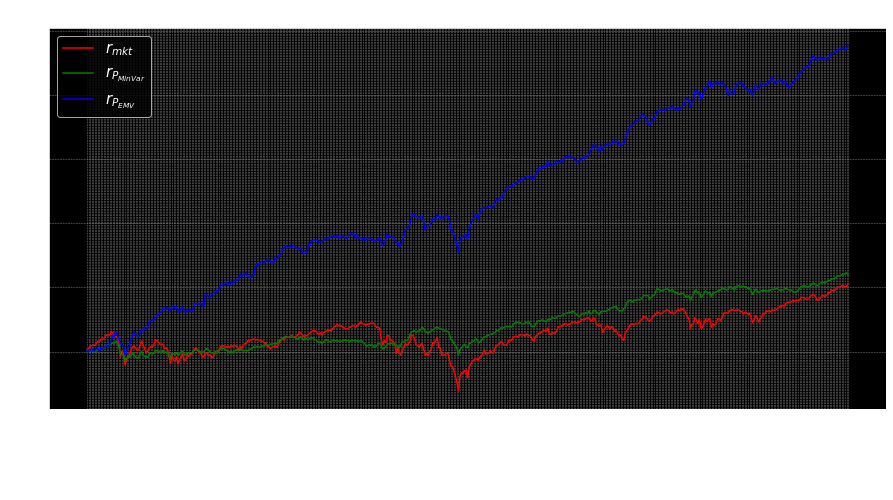

In [25]:
vs.Accum_ts(accum)